In [46]:
import pandas as pd
from os import walk
import numpy as np

In [47]:
datasets_names = []
path_df = '../datasets/original_files/'
for (dirpath, dirnames, filenames) in walk(path_df):
    datasets_names.extend(filenames)
    break
datasets_names

['austin-listings.csv.gz',
 'boston-listings.csv.gz',
 'denver-listings.csv.gz',
 'los_angeles-listings.csv.gz',
 'new_orleans-listings.csv.gz',
 'new_york_city-listings.csv.gz',
 'san_diego-listings.csv.gz']

In [48]:
dataFrame = False
first = True
for name in datasets_names:
    if(first):
        first = False
        dataFrame = pd.read_csv(path_df+name, compression='gzip')
        dataFrame.set_index('id', drop=False, inplace=True)
        dataFrame['city2'] = name[:-16]
        print('adding', len(dataFrame), 'rows')
    else:
        _tmpDf = pd.read_csv(path_df+name, compression='gzip')
        _tmpDf.set_index('id', drop=False, inplace=True)
        _tmpDf['city2'] = name[:-16]
        print('adding', len(_tmpDf), 'rows')
        dataFrame = pd.concat([dataFrame, _tmpDf])
        del _tmpDf
print('total rows:', len(dataFrame))
dataFrame.head()

adding 11668 rows
adding 3799 rows
adding 4868 rows
adding 38481 rows
adding 7211 rows
adding 50796 rows
adding 13927 rows
total rows: 130750


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city2
id,,,,,,,,,,,,,,,,,,,,,
2265,2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18,austin
5245,5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07,austin
5456,5456,https://www.airbnb.com/rooms/5456,20200317143754,2020-03-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...,...,f,strict_14_with_grace_period,f,t,1,1,0,0,3.94,austin
5769,5769,https://www.airbnb.com/rooms/5769,20200317143754,2020-03-17,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,moderate,t,t,1,0,1,0,2.12,austin
6413,6413,https://www.airbnb.com/rooms/6413,20200317143754,2020-03-17,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...",!!!!! SXSW info !!!!! Presently open (again!) ...,"Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,...,f,strict_14_with_grace_period,f,f,1,1,0,0,0.90,austin


## Limpieza

In [49]:
# Filtra precio
from scipy import stats
dataFrame.loc[:,  'price'] = dataFrame.price.apply(lambda x: x[1:-3].replace(',', '')).astype(int)

In [50]:
num_cols = [
    "reviews_per_month", "review_scores_communication","review_scores_location","review_scores_value",
    "number_of_reviews_ltm","review_scores_cleanliness",
    "review_scores_checkin","availability_30","availability_60","availability_90","availability_365",
    "review_scores_accuracy","minimum_nights","maximum_nights",
    "calculated_host_listings_count","calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms",
    "host_listings_count","number_of_reviews",
    "accommodates","bathrooms","bedrooms","beds","guests_included",
]

print(len(
    dataFrame
))

#Filtra Outliers
dataFrame = dataFrame[(np.abs(stats.zscore(dataFrame[num_cols].fillna(dataFrame[num_cols].median()))) < 3).all(axis=1)] 

#Filtra Nans
dataFrame = dataFrame[~dataFrame[['review_scores_communication', 'review_scores_location', 'review_scores_value', 'review_scores_accuracy']]\
.isna().all(axis=1)]

dataFrame = dataFrame[dataFrame.number_of_reviews > 2]
dataFrame = dataFrame[dataFrame.price > 0]

dataFrame = dataFrame[(np.abs(stats.zscore(dataFrame[['price']])) < 3)]



print(len(
    dataFrame
))

130750
71618


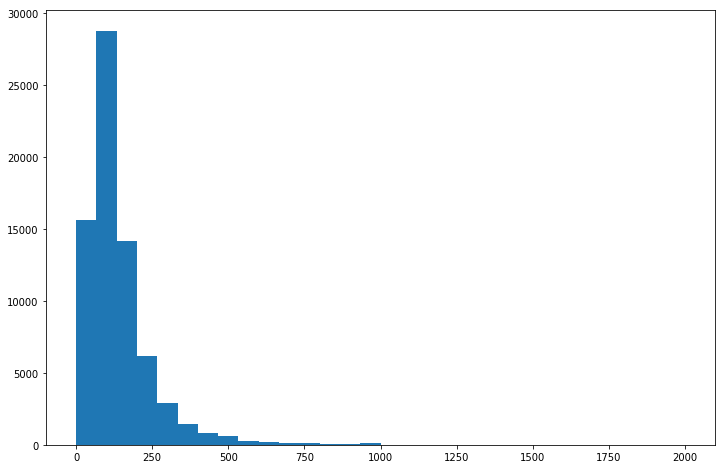

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.hist(dataFrame.price, range=(0, 2000), bins=30)
plt.show()

In [52]:
# dataFrame = dataFrame[dataFrame.price <= 1000]

In [53]:
len(dataFrame)

71618

In [54]:
import importlib
import load_transform_pipeline #import the module here, so that it can be reloaded.
importlib.reload(load_transform_pipeline)

transform_pipeline = load_transform_pipeline.load_model('../models/transformDataPipeline__not_fitted.pkl')

transform_pipeline

FeatureUnion(n_jobs=None,
       transformer_list=[('numerical_pipeline', Pipeline(memory=None,
     steps=[('num_selector', FeatureSelector(feature_names=None)), ('num_imputer', NumericalImputer(default_strategy=None)), ('num_transformer', NumericalTransformer(log_transform=None)), ('std_scaler', StandardScaler(copy=True, with_mea...l=None, geoCols=None)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)

In [55]:
from sklearn.model_selection import train_test_split

y = dataFrame.price
X = dataFrame
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train_df, X_val_df, y_train, y_val = train_test_split(X_train_df, y_train, test_size=0.25, random_state=42)

In [ ]:
transform_pipeline.fit(X_train_df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
D:\Usuarios\Matias\Documentos\Matias\Trabajos\Jupyter\DH ia\keras-airbnb-prediction\notebooks\load_transform_pipeline.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[col] = X[col].astype(float)
D:\Usuarios\Matias\Documentos\Matias\Trabajos\Jupyter\DH ia\keras-airbnb-prediction\notebooks\load_transform_pipeline.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [ ]:
# transform_pipeline.transform(X_train_df)

In [ ]:
X_train = transform_pipeline.transform(X_train_df)
X_test = transform_pipeline.transform(X_test_df)
X_val = transform_pipeline.transform(X_val_df)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

In [ ]:
data = {
    'X_train_df': X_train_df,
    'X_test_df': X_test_df,
    'X_val_df': X_val_df,
    'X_train': X_train,
    'X_test': X_test,
    'X_val': X_val,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val,
    'transform_pipeline': transform_pipeline
}
import pickle
with open("../models/data.pkl", 'wb') as pfile:
    pickle.dump(data, pfile, protocol=pickle.HIGHEST_PROTOCOL)